# Building Blocks of a Machine Learning System: Building/Reading a Working MNIST Classifier

## Copyright notice

Parts of this code are adapted from the [Pytorch example](https://github.com/pytorch/examples/blob/master/mnist/main.py), [BSD-3-Clause License](https://github.com/pytorch/examples/blob/master/LICENSE). This version (c) 2019 Fabian Offert, [MIT License](LICENSE).

![](https://imgs.xkcd.com/comics/machine_learning.png)

## Imports

In [1]:
import torch as t
import torch.nn as nn
import torch.nn.functional as f
import torchvision as tv
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import expit as sigmoid
from IPython.lib.display import YouTubeVideo
import sys
sys.path.append('lib/')
from esu_util import show_img, np_PIL, PIL_np, deprocess

## But what is a neural network?

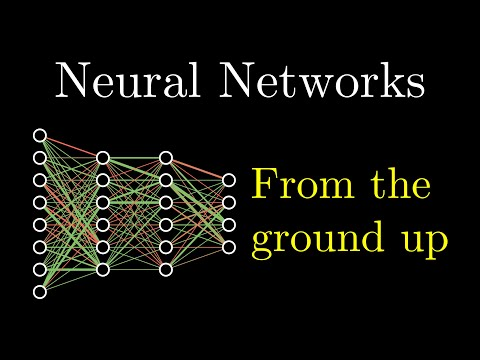

In [2]:
YouTubeVideo('aircAruvnKk')

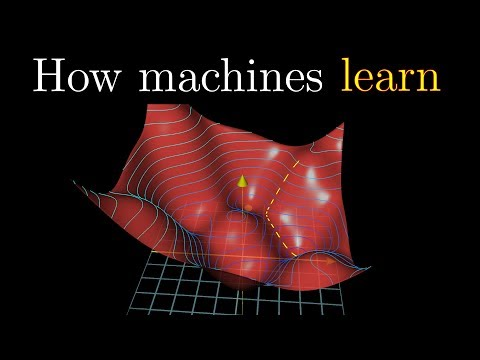

In [3]:
YouTubeVideo('IHZwWFHWa-w')

## Building the model

An example CNN architecture:

![](https://ujwlkarn.files.wordpress.com/2016/08/screen-shot-2016-08-07-at-4-59-29-pm.png?w=748)

Our concrete CNN architecture:

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1) # in, out, size, stride 
        self.conv2 = nn.Conv2d(20, 50, 5, 1) # in, out, size, stride 
        self.fc1 = nn.Linear(4*4*50, 500) # in, out
        self.fc2 = nn.Linear(500, 10) # in, out

    def forward(self, x):
        # [64, 1, 28, 28]
        x = f.relu(self.conv1(x)) # [64, 20, 24, 24]
        x = f.max_pool2d(x, 2, 2) # [64, 20, 12, 12]
        x = f.relu(self.conv2(x)) # [64, 50, 8, 8]
        x = f.max_pool2d(x, 2, 2) # [64, 50, 4, 4]
        x = x.view(-1, 4*4*50) # [64, 800]
        x = f.relu(self.fc1(x)) # [64, 500]
        x = self.fc2(x) # [64, 10]
        x = f.log_softmax(x, dim=1) # [64, 10]
        return x

## PyTorch building blocks explained

### nn.Conv2d: Convolutional layer 

https://pytorch.org/docs/stable/nn.html#conv2d

Defines a number of trainable discrete convolution kernels with fixed size and stride. Most important feature of convolutional layers: much smaller than fully connected layers, as only the kernel weights are learned!

![](img/conv.gif) 

### f.max_pool2d: Max pooling layer

https://pytorch.org/docs/stable/nn.html#maxpool2d

Only keeps the maximum value from a region of values.

![](img/pooling.jpg)

### nn.Linear: Fully connected layer

https://pytorch.org/docs/stable/nn.html#linear

This is the standard, multilayer perceptron layer, where every unit of a layer is connected to every unit of the layer before and after. 

### f.relu: ReLu activation function

[Rectified linear units](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) are the most popular neural network units at the time of writing. Despite their "linear look", the [activation function](https://en.wikipedia.org/wiki/Activation_function) used: 

$$f(x)=\max(0,x)$$

is actually nonlinear ([piecewise-linear](https://en.wikipedia.org/wiki/Piecewise_linear_function), to be precise) *and* differentiable. Why nonlinear? Well, a linear function has to satisfy the condition 

$$\forall_{x,y}: f(x) + f(y) = f(x+y)$$

For ReLu, 

$$f(-1) = -1$$
$$f(1) = 1$$
$$f(0) = 0$$ 

Its derivative is then simply 

$$f'(x)={\begin{cases}0&{\text{for }}x<0\\1&{\text{for }}x\geq 0\end{cases}}$$

Interestingly, the "almost-linearity" of ReLus does not impede their universality in approximating functions (see [these examples](https://www.quora.com/Is-a-single-layered-ReLu-network-still-a-universal-approximator/answer/Conner-Davis-2)).

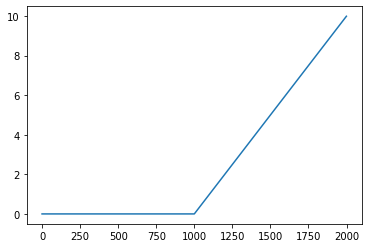

In [5]:
plt.plot([max(0, x) for x in np.arange(-10.0,10.0,0.01)])
plt.show()

### f.log_softmax + f.nll_loss: Logarithm of sigmoid loss function, or Negative Log Likelihood (NLL)

https://pytorch.org/docs/stable/nn.html#log-softmax and https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss

The [sigmoid function](https://en.wikipedia.org/wiki/Logistic_function), also called logistic function, looks roughly like the simple step function but has non-zero gradients everywhere, which makes it fully differentiable. It is defined as

$$f(x)={\frac {1}{1+e^{-x}}}$$

with the derivative

$$f'(x)=f(x)(1-f(x))$$

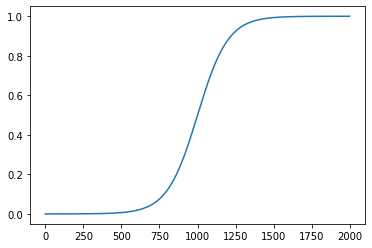

In [6]:
plt.plot([sigmoid(x) for x in np.arange(-10.0,10.0,0.01)])
plt.show()

/home/fabian/miniconda3/envs/py37w/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


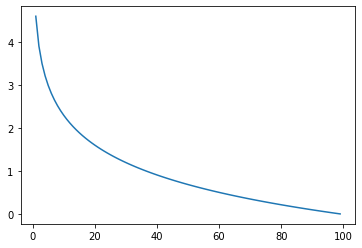

In [7]:
plt.plot([-np.log(x) for x in np.arange(0.0,1.0,0.01)])
plt.show()

### f.nll_loss.backward(): Backpropagation via stochastic gradient descent

First, a quick derivative reminder. The [derivative](https://en.wikipedia.org/wiki/Derivative) $f'(x)$ describes the *rate of change*, the *sensitivity* of a function $f$ with regard to its input $x$. Intuitively, this rate of change is the *gradient* of the function at $x$.

$$f'(x) = \frac{df}{dx} = \lim_{h \to 0} \frac{f(x+h)-f(x)}{h}$$

[Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) is based on the observation that if the multi-variable function $f$ is defined and differentiable in a neighborhood of a point $x$, then $f(x)$ decreases fastest if one goes from $x$ in the direction of the negative gradient of $f$ at $x$, $f(x) -\nabla f(x)$. The algorithm for a system with the loss function $Loss$ would then be

$$w_n \leftarrow w_n - \underbrace{\eta}_\text{step size} \nabla_{w_{n}} Loss(w_n)$$

for every training sample, where $\nabla_{w_{n}}$ ([Del](https://en.wikipedia.org/wiki/Del)) denotes the partial derivative w. r. t. the weight $w_n$, which can usually be derived by means of the [chain rule](https://en.wikipedia.org/wiki/Chain_rule): 

$$(f\circ g)'=(f'\circ g)\cdot g'$$

[Stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) adds an additional element to the process to increase throughput: batch size. Instead of supplying one training sample per iteration (where iteration defines one forward and backward pass), multiple (random) samples are concatenated and the network is trained on these concatenated "mini-batches". Essentially, we are trading dimensionality for speed which is intuitively a good choice if we use GPUs for training.

Example: $f(x)=x^4−3x^3+2$, with derivative $f'(x)=4x^3−9x^2$

In [8]:
# From calculation, it is expected that the local minimum occurs at x=9/4

x = 6 # The algorithm starts at x=6
eta = 0.01 # Step size multiplier
precision = 0.00001
previous_step_size = 1/precision # Some large value

df = lambda x: 4 * x**3 - 9 * x**2

while previous_step_size > precision:
    prev_x = x
    x += -eta * df(prev_x)
    previous_step_size = abs(x - prev_x)

print("The local minimum occurs at " + str(x))

The local minimum occurs at 2.2499646074278457


## Training and testing

In [9]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = f.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        # item(): https://pytorch.org/docs/stable/tensors.html#torch.Tensor.item
        if batch_idx % 250 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [10]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with t.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += f.nll_loss(output, target, reduction='sum').item() # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # Get the index of the max log-probability
            # eq(): https://pytorch.org/docs/stable/torch.html#torch.eq
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

## Define components

In [11]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")

transform = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.1307,), (0.3081,))])

train_set = tv.datasets.MNIST('.', train=True, transform=transform, download=True)
test_set = tv.datasets.MNIST('.', train=False, transform=transform)
train_loader = t.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = t.utils.data.DataLoader(test_set, batch_size=1000, shuffle=True)

model = Net().to(device)
optimizer = t.optim.SGD(model.parameters(), lr=0.01)

## Peek into the dataset

In [12]:
n = 0
for data, target in train_loader:
    
    # Just use first datapoint of batch
    tensor = data[0]
    
    # Remove batch dimension
    tensor = tensor.data.squeeze() 
        
    # To CPU and numpy array
    img = tensor.cpu().numpy() 

    # Clip to visible range
    img = np.clip(img, 0., 1.) # Clip to 0./1. range
    
    # 0./1. range to 0./255. range
    img *= 255.
    
    # To PIL-friendly datatype
    img = img.astype(np.uint8)
    
    show_img(img)
    n+=1
    if (n==10):
        break

## Run everything

In [13]:
for epoch in range(1, 10 + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.324633
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.620063
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.219139
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.234155

Test set: Average loss: 0.1812, Accuracy: 9452/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.206915
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.180585
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.125139
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.146723

Test set: Average loss: 0.1076, Accuracy: 9659/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.259393
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.036449
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.064765
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.059854

Test set: Average loss: 0.0740, Accuracy: 9778/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.021581
Train Epoch: 4 [16000/60000 (27%)]	Loss: 0.063025
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.074224
Train Epoch: 4 [48000/60000 (80%)]	Loss: 0.043346

Test set: Average loss: 0.0546, Accu